In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings

In [2]:
#Load in salinity data and take annual mean
mean_annual_sal=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_sal=np.empty([12,180,360])
    surface_sal[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        sal=xr.open_dataset(f)['salinity']
        sal=sal.where(sal<999)
        surface_sal[i-1,:,:]=sal[:,:,0]
    surface_sal=xr.DataArray(surface_sal,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_sal=surface_sal.mean('month')
    mean_annual_sal[j-1973,:,:]=surface_sal 
mean_annual_sal=xr.DataArray(mean_annual_sal[3:48,:,:],dims=["year","lat","lon"],coords=[np.linspace(1975,2019,45),lat,lon])

In [20]:
slopes=np.empty([np.size(mean_annual_sal.where(mean_annual_sal.lat<55).lat),np.size(mean_annual_sal.where(mean_annual_sal.lat<55).lon)])
mean_sal=np.empty([np.size(mean_annual_sal.where(mean_annual_sal.lat<55).lat),np.size(mean_annual_sal.where(mean_annual_sal.lat<55).lon)])
for j in list(range(0,np.size(mean_annual_sal.where(mean_annual_sal.lat<55).lon))):
    for i in list(range(0,np.size(mean_annual_sal.where(mean_annual_sal.lat<55).lat))):
            slope, intercept, r_value, p_value, std_err=stats.linregress(np.linspace(1,45,45),mean_annual_sal[:,i,j])
            slopes[i,j]=slope*45
            mean_sal[i,j]=mean_annual_sal[0:10,i,j].mean('year')

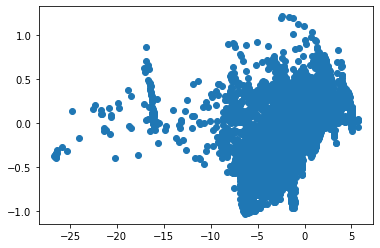

In [21]:
plt.scatter((mean_sal-np.nanmean(mean_sal)),slopes)
from scipy import stats
mask = ~np.isnan(np.reshape((np.array(mean_sal-np.nanmean(mean_sal))),(1,180*360))) & ~np.isnan(np.reshape(np.array(slopes),(1,180*360)))
p=scipy.stats.mstats.linregress(x=np.reshape((np.array(mean_sal-np.nanmean(mean_sal))),(1,180*360))[mask], y=np.reshape(np.array(slopes),(1,180*360))[mask])


In [22]:
#As noted in Cheng et al, the relationship between SSS amplification and E-P amplification in DUrack et al. is around 1.7
print(p.slope*100/1.7/0.8867) #here 0.8867 is the surface air temp
print(p.stderr*100/1.7/0.8867)

3.1542915104757965
0.027810332683007997


In [23]:
print(p.slope*100/3/0.8867) #here 0.8867 is the surface air temp
print(p.stderr*100/3/0.8867)

1.7874318559362845
0.015759188520371198


In [ ]:
mean_sal=np.empty([np.size(mean_annual_sal.where(mean_annual_sal.lat<65).lat),np.size(mean_annual_sal.where(mean_annual_sal.lat<65).lon)])

In [17]:
A=mean_annual_sal[40:45,:,:].mean('year')-(slopes+mean_annual_sal[0:10,:,:].mean('year'))

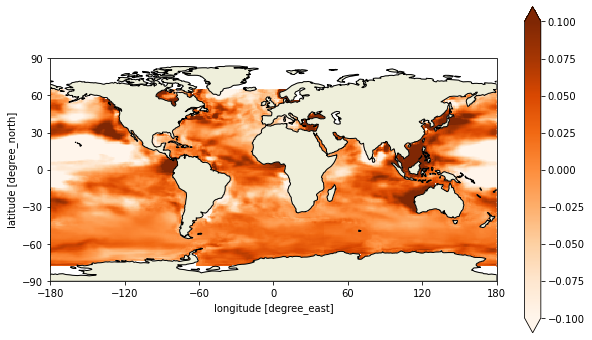

In [24]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(10,6)) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p1=(A.where(A.lat<65)).plot(vmax=0.1,ax=ax,cmap='Oranges')
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

## Test on model data

In [4]:
#load in one ensemble member and use it to make a regridder object
f='/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.SALT.192001-200512.nc'
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
lat = xr.open_dataset(f)['TLAT']
lon = xr.open_dataset(f)['TLONG']
time=xr.open_dataset(f)['time']
depth=xr.open_dataset(f)['z_t']
salt2=xr.open_dataset(f)['SALT']

ds_out = xe.util.grid_global(1, 1)
salt2 = salt2.rename({"TLAT": "lat", "TLONG": "lon"})
salt2=salt2.drop("ULAT")
salt2=salt2.drop("ULONG")
regridder_forcesm = xe.Regridder(salt2[:,0,:,:], ds_out, "bilinear",periodic=True) #this is now the regridder object that can be applied to any of the original CESM fields
regrid_cesm = regridder_forcesm(salt2[:,0,:,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [5]:
import pickle
with open("/scratch/abf376/regridded_salt_1920to2005_historical", "rb") as fp:   # Unpickling regridded salt 1920 to 2005
    regridded_salt= pickle.load(fp)

with open("/scratch/abf376/regridded_salt_2006to2080_rcp8.5", "rb") as fp:   # Unpickling regridded salt 2006 to 2080
    regridded_salt_2005on= pickle.load(fp)
    
with open("/scratch/abf376/regridded_temp", "rb") as fp:   # Unpickling regridded temperature 1920 to 2005
    regridded_temp= pickle.load(fp)
    
with open("/scratch/abf376/regridded_temp_2006to2080_rcp8.5", "rb") as fp:   # Unpickling regridded temperature 2006 to 2080
    regridded_temp_2005on= pickle.load(fp)

In [21]:
#Take ensemble mean and then create a new object which is ensemble mean over the period 1970 to 2025
salt_avg_pre2005=sum(regridded_salt)/34
salt_avg_pre2005=salt_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
lats=salt_avg_pre2005.lat[:,0]
lons=salt_avg_pre2005.lon[0,:]
salt_avg_pre2005=salt_avg_pre2005.assign_coords(latitude=salt_avg_pre2005.lat[:,0],longitude=salt_avg_pre2005.lon[0,:])

salt_avg_2005on=sum(regridded_salt_2005on)/34
salt_avg_2005on=salt_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
salt_avg_2005on=salt_avg_2005on.assign_coords(latitude=salt_avg_2005on.lat[:,0],longitude=salt_avg_2005on.lon[0,:])

salt_avg=xr.concat([salt_avg_pre2005,salt_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
salt_avg_1975to2020=salt_avg[12*55:12*105,:,:]

In [22]:
salt_cesm=np.empty([45,180,360])
for j in range(0,45):
    salt_cesm[j,:,:]=(salt_avg_1975to2020[j*12:(j+1)*12,:,:].mean('time')).where(salt_avg_1975to2020.latitude<65)
salt_cesm=xr.DataArray(data=salt_cesm,dims=["time","latitude","longitude"])
salt_cesm=salt_cesm.assign_coords(time=np.linspace(1975,2019,45),latitude=lats,longitude=lons)

In [67]:
slopes_error=np.empty([np.size(salt_avg_1975to2020.where(salt_avg_1975to2020.latitude<65).latitude),np.size(salt_avg_1975to2020.where(salt_avg_1975to2020.latitude<65).longitude)]) #we will hold in this object the error on the y variable for when we do a weighted regression
slopes=np.empty([np.size(salt_avg_1975to2020.where(salt_avg_1975to2020.latitude<65).latitude),np.size(salt_avg_1975to2020.where(salt_avg_1975to2020.latitude<65).longitude)])
mean_sal=np.empty([np.size(salt_avg_1975to2020.where(salt_avg_1975to2020.latitude<65).latitude),np.size(salt_avg_1975to2020.where(salt_avg_1975to2020.latitude<65).longitude)])
for j in list(range(0,np.size(salt_avg_1975to2020.where(salt_avg_1975to2020.latitude<65).longitude))):
    for i in list(range(0,np.size(salt_avg_1975to2020.where(salt_avg_1975to2020.latitude<65).latitude))):
            slope, intercept, r_value, p_value, std_err=stats.linregress(np.linspace(1,45,45),salt_cesm[:,i,j])
            slopes[i,j]=slope*45
            slopes_error[i,j]=std_err #this is the error associated with the original linear fit 
            mean_sal[i,j]=salt_cesm[0:10,i,j].mean('time')
slopes=xr.DataArray(data=slopes,dims=["latitude","longitude"])

In [68]:
slopes=slopes.assign_coords(latitude=lats,longitude=lons)

mean_sal=xr.DataArray(data=mean_sal,dims=["latitude","longitude"])
mean_sal=mean_sal.assign_coords(latitude=lats,longitude=lons)

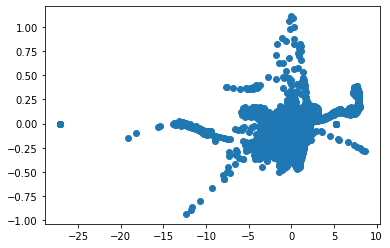

In [69]:
plt.scatter((mean_sal-mean_sal.mean()).where(mean_sal.latitude<65),slopes.where(mean_sal.latitude<65))
from scipy import stats
mask = ~np.isnan(np.reshape((np.array(mean_sal-mean_sal.mean())),(1,180*360))) & ~np.isnan(np.reshape(np.array(slopes),(1,180*360)))
p=scipy.stats.mstats.linregress(x=np.reshape((np.array(mean_sal-mean_sal.mean())),(1,180*360))[mask], y=np.reshape(np.array(slopes),(1,180*360))[mask])
